In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import importlib as imp
import generator as gen
import data_visualization as viz
import multiclass_logistic_regression as mlr

# GOAL
Implémenter SDCA pour la classification multiclasse de base (en regularisant le biais).

## Generate data

In [3]:
imp.reload(gen)
imp.reload(viz)
imp.reload(mlr)
pass

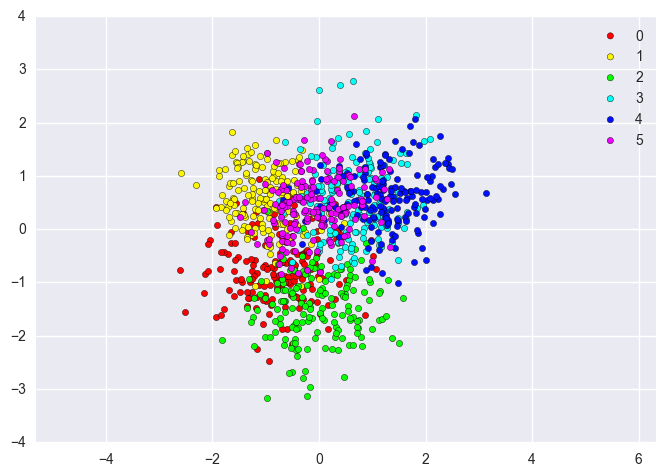

In [4]:
n = 1000
d = 20
k = 6
bias = 1
x,y,mu,sig = gen.gengaussianmixture(n,d,k,scale=.01,randomcov=True)
x = gen.standardize(x)
x = np.concatenate([x, bias*np.ones([n, 1])], axis=1)
viz.plot_data(x,y)

## Line Search
The function for which we want to find a zero is of the form : 

$$u(\gamma) = - \gamma\frac{\|\Delta_i\|^2\|x_i\|^2}{\lambda n}+\frac{\Delta_i^TWx_i}{\lambda n} -\sum_y \Delta_i(y)\log(\alpha_i(y)+\gamma\Delta_i(y)) $$
$$u(\gamma) = - \gamma a + b - \sum_y \Delta_i(y)\log(\alpha_i(y)+\gamma\Delta_i(y))$$
$$u'(\gamma) = -a - \sum_y \frac{\Delta_y^2}{\alpha_i(y) + \gamma \Delta_i(y)}$$

where $\Delta_i$ is the ascent direction, W is the primal parameter matrix and $\gamma$ is the search parameter in [0,1]. The linear coefficient a is always positive. 
Since the zero of this decreasing function can be out of [0,1], we stop the line search with $\gamma =1$ if $u(1)\geq0$, and with $\gamma=0$ if $u(0)\leq 0$.

In [4]:
imp.reload(mlr)

<module 'multiclass_logistic_regression' from '/Users/remilepriol/Dropbox/intership2017/code/multiclass_logistic_regression.py'>

## Test SDCA

In [9]:
imp.reload(mlr)
reg = 1/n
model = mlr.MulticlassLogisticRegression(reg,x,y)

In [10]:
model.w = np.random.randn(k,d+1)
print(model.negloglikelihood(x,y).mean())
model.alpha = model.primal2dual(x)
print(model.entropy().mean())
print(model.duality_gap(x,y))

3.83736493066
0.457881137771
918.249728374


In [11]:
alpha0 = 1/k * np.ones([n,k])
#alpha0 = np.random.rand(n,k)
#alpha0/= alpha0.sum(axis=1,keepdims=True)

In [12]:
obj_sdca,time_sdca = model.sdca(x,y,alpha0,precision=1e-8,non_uniformity=0)

Perfect line search : 49012 	 Negative ls : 5 	 Positive ls : 984


In [13]:
obj_sdca_halfuniform,time_sdca_halfuniform = model.sdca(x,y,alpha0,precision=1e-8,non_uniformity=.5)

Perfect line search : 49013 	 Negative ls : 4 	 Positive ls : 984


In [14]:
obj_nonuniform, time_nonuniform = model.sdca(x,y,alpha0,precision=1e-8,non_uniformity=1)

Perfect line search : 49012 	 Negative ls : 2 	 Positive ls : 987


/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10
/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Library/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10


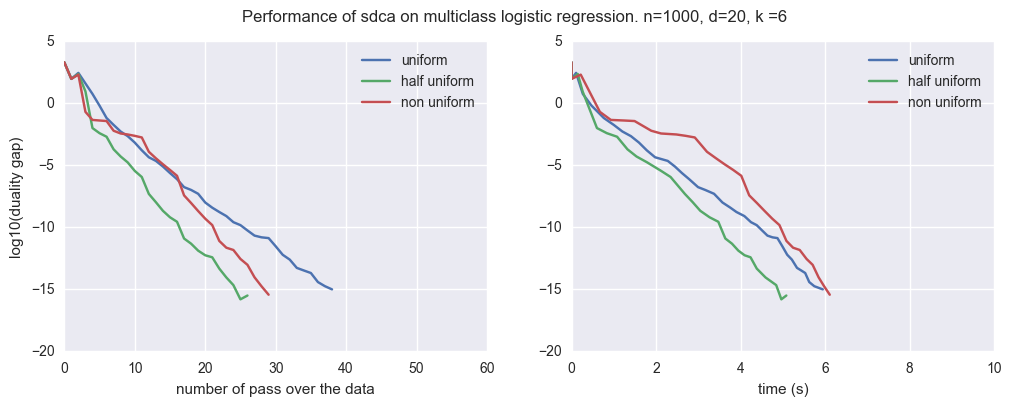

In [15]:
plt.figure(figsize=(12,4))
plt.suptitle("Performance of sdca on multiclass logistic regression. n=%i, d=%i, k =%i"%(n,d,k))
plt.subplot(1,2,1)
plt.ylabel("log10(duality gap)")
plt.plot(np.log10(obj_sdca),label='uniform')
plt.plot(np.log10(obj_sdca_halfuniform),label='half uniform')
plt.plot(np.log10(obj_nonuniform),label='non uniform')
plt.legend(loc='best')
plt.xlabel("number of pass over the data")
plt.subplot(1,2,2)
plt.plot(time_sdca, np.log10(obj_sdca),label='uniform')
plt.plot(time_sdca_halfuniform, np.log10(obj_sdca_halfuniform),label='half uniform')
plt.plot(time_nonuniform, np.log10(obj_nonuniform),label='non uniform')
plt.legend(loc='best')
plt.xlabel("time (s)")
plt.savefig("images/nonuniform_is_better.pdf")

ValueError: shapes (40000,3) and (21,6) not aligned: 3 (dim 1) != 21 (dim 0)

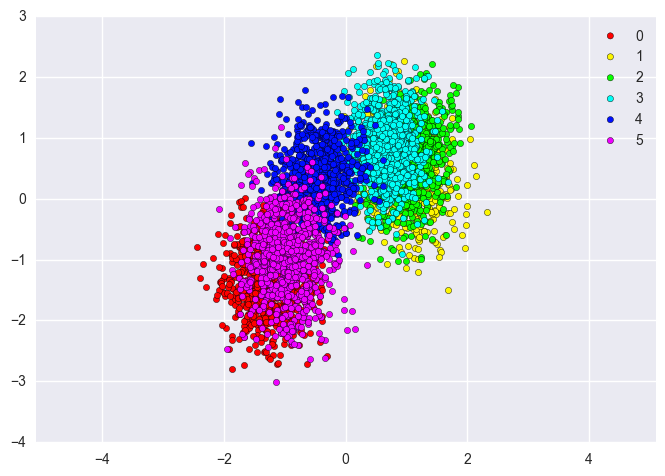

In [12]:
resolution = 200
viz.plot_data(x,y)
viz.plot_areas(model.prediction,bias,resolution)
plt.title("Optimal classification boundaries for n=%i points \n in dimension d=%i drawn from k=%i gaussians."%(n,d,k))
plt.tight_layout()
#plt.savefig("images/linear_classification.pdf", bbox_inches='tight')

In [ ]:
import sklearn.linear_model as skl

Mon algorithme impose une pénalité bien plus importante à w que scikit learn, alors qu'ils ont la même variable de régularisation égale à 1. sklearn ne divise pas par n la somme des loglikelihoods (ie il prend la somme et non pas la moyenne) ! Il faut donc que je mette reg = 1/n pour être à armes égales.

In [41]:
skreg = skl.LogisticRegression(fit_intercept=False,multi_class='multinomial',solver='sag',C=1/n/reg)
skreg.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

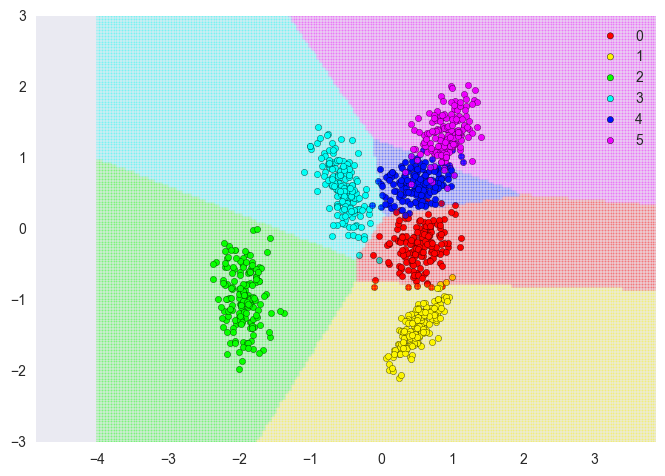

In [42]:
viz.plot_data(x,y)
viz.plot_areas(skreg.predict,bias,resolution)

In [43]:
print("score of sklearn :",skreg.score(x,y))
save_coefs = skreg.coef_
skreg.coef_ = model.w
print("score of sdca :",skreg.score(x,y))
skreg.coef_ = save_coefs

score of sklearn : 0.955
score of sdca : 0.955


In [44]:
save_coefs = model.w
model.w = skreg.coef_
print("objective of sklearn :",model.primal_objective(x,y))
model.w = save_coefs
print("objective of sdca :",model.primal_objective(x,y))

objective of sklearn : 0.336116833209
objective of sdca : 0.336116805056


In [113]:
import cProfile

In [115]:
cProfile.run("obj_sdca_halfuniform,time_sdca_halfuniform = model.sdca(x,y,alpha0,precision=1e-8,non_uniformity=.5)",
             filename="profiling.txt",sort="time")

Perfect line search : 120011 	 Negative ls : 4 	 Positive ls : 4986


In [ ]:
import pstat